In [24]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
df = pd.read_csv('qb.train.csv')

In [5]:
df.head()

,row,body_score,page,answer,text,category,tournaments,answer_type,corr,inlinks
0,1,127.398036,Comus (John Milton),Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,work,True,62
1,2,50.212336,Circe,Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,None,False,5
2,3,44.767071,Satyr,Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,None,False,6
3,4,44.058274,Philip K. Dick,Wilfred Owen,This author is convinced by another to publish...,Literature,2009 ACF Winter,people,False,22
4,5,40.675249,Honore de Balzac,Wilfred Owen,This author is convinced by another to publish...,Literature,2009 ACF Winter,None,False,0


In [6]:
df.answer_type.value_counts().count()

9

In [7]:
df.tournaments.value_counts().count()

76

We will check all teh unique values and compare if any value from the test dataset is missing in train dataset

In [8]:
df.tournaments.unique()

array(['2000 ACF Nationals', '2009 ACF Winter', '2001 ACF Fall',
       '2001 ACF Regionals', '2001 ACF Nationals', '2000 ACF Regionals',
       '1999 ACF Nationals', '2002 ACF Fall', '2007 Terrapin',
       '2002 ACF Regionals', '2002 ACF Nationals', '2009 ACF Nationals',
       '2003 ACF Regionals', '2008 Cardinal Classic XVII',
       '2003 ACF Nationals', '2008 Chicago Open', '2004 ACF Fall',
       '2004 ACF Regionals', '2008 Chicago Open Literature Singles',
       '2004 ACF Nationals', '2010 Chicago Open', '2005 ACF Fall',
       '2008 FICHTE', '2009 ACF Fall', '2005 ACF Regionals',
       '2005 ACF Nationals', '2008 Gunpei Yokoi Memorial Open',
       '2008 MCMNT', '2006 ACF Regionals', '2008 MUT',
       '1999 ACF Regionals', '2008 Penn Bowl', '2003 ACF Fall',
       '2007 ACF Regionals', '2008 ACF Regionals', '2006 ACF Fall',
       '2006 ACF Nationals', '2007 ACF Fall', '2007 ACF Nationals',
       '2008 ACF Nationals', '2008 Sun N Fun IX', '2008 ACF Fall',
       '2009 ACF 

In [9]:
df.isnull().sum()

row            0
body_score     0
page           0
answer         0
text           0
category       0
tournaments    0
answer_type    0
corr           0
inlinks        0
dtype: int64

# Initially, we will build the model using only page and answer just to check how accuracy will be affected

In [10]:
X = df.iloc[:, [2,3]].values
y = df.iloc[:, 8].values

In [11]:
print(y)

[ True False False ... False False  True]


In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder_page = LabelEncoder()
label_encoder_answer = LabelEncoder()

label_encoder_page.fit(X[:,0]) #never enter multiple column here, it doesn't work
X[:,0] = label_encoder_page.transform(X[:,0])

label_encoder_answer.fit(X[:,1]) #never enter multiple column here, it doesn't work
X[:,1] = label_encoder_answer.transform(X[:,1])

one_hot_encoder = OneHotEncoder(categorical_features=[0,1], sparse=False)
one_hot_encoder.fit(X)
X= one_hot_encoder.transform(X)

#X = np.delete(X, one_hot_encoder.feature_indices_[ : -1], 1)

In [13]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
label_encoder_corr = LabelEncoder()
label_encoder_corr.fit(y) #never enter multiple column here, it doesn't work
y = label_encoder_corr.transform(y)

In order to check the accuracy of our model, we will split the train dataset into train and test 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0 ) 

In [14]:
from sklearn.linear_model import LogisticRegression

glm_model = LogisticRegression()
glm_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
y_pred = glm_model.predict(X_test)
y_pred_prob = glm_model.predict_proba(X_test) [:, 1]

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[739, 190],
       [197, 490]])

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.760519801980198

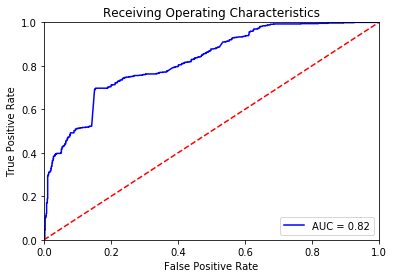

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# So, we are getting 76% accuracy with the columns page and answers. However, please note that the page values are all different in the actual train and test dataset and answer column will not be present in the test dataset. Hence, we will create a model using columns: body_score, tournaments, answer_type and inlinks

In [14]:
X = df.iloc[:, [1,6,7,9]].values
y = df.iloc[:, 8].values 

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder_tournaments = LabelEncoder()
label_encoder_answertype = LabelEncoder()

label_encoder_tournaments.fit(X[:,1]) #never enter multiple column here, it doesn't work
X[:,1] = label_encoder_tournaments.transform(X[:,1])

label_encoder_answertype.fit(X[:,2]) #never enter multiple column here, it doesn't work
X[:,2] = label_encoder_answertype.transform(X[:,2])

one_hot_encoder = OneHotEncoder(categorical_features=[1,2], sparse=False)
one_hot_encoder.fit(X)
X= one_hot_encoder.transform(X)

In [16]:
label_encoder_corr = LabelEncoder()
label_encoder_corr.fit(y) #never enter multiple column here, it doesn't work
y = label_encoder_corr.transform(y)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0 ) 

# We will be bulding different Machine Learning models and comparing the accuracy score and area under curve(auc) and storing it in a df called accuracy_matrix

In [18]:
columns = ['Model_Name', 'accuracy_score', 'auc']
accuracy_matrix = pd.DataFrame(columns=columns)

# Creating a Logistic Regression Model

In [19]:
from sklearn.linear_model import LogisticRegression

glm_model = LogisticRegression()
glm_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
y_pred = glm_model.predict(X_test)
y_pred_prob = glm_model.predict_proba(X_test) [:, 1]

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6670792079207921

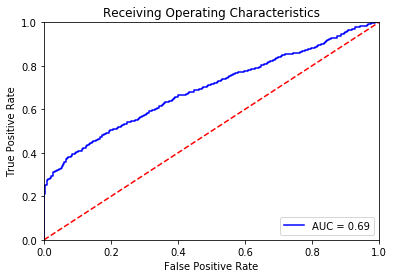

In [27]:
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [28]:
accuracy_matrix.loc[0] = ['Logistic Regression', 66.7, 0.69] 

# Adaptive Boosting Classifier Model

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_model = AdaBoostClassifier()
ada_boost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [30]:
y_pred = ada_boost_model.predict(X_test)
y_pred_prob = ada_boost_model.predict_proba(X_test) [:, 1]

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.780940594059406

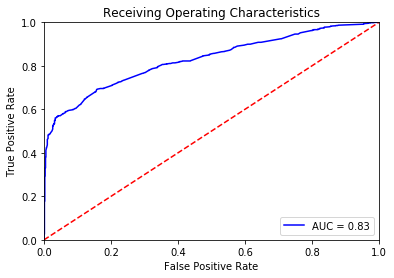

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [33]:
accuracy_matrix.loc[1] = ['Adaptive Boosting Classifier', 78, 0.83] 

# Building Decision Tree Model

In [34]:
from sklearn.tree import DecisionTreeClassifier

dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
y_pred = dtc_model.predict(X_test)
y_pred_prob = dtc_model.predict_proba(X_test) [:, 1]

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7178217821782178

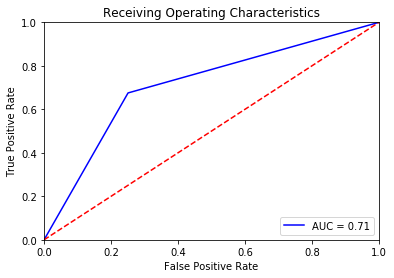

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [38]:
accuracy_matrix.loc[2] = ['Decision Tree', 71.7, 0.71] 

# Building Random Forest Model

In [39]:
#Using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test) [:, 1]

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7772277227722773

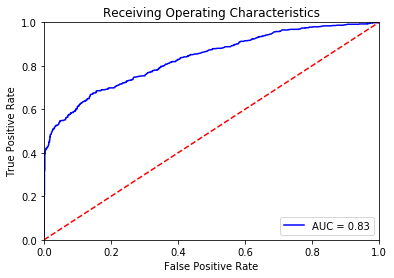

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [48]:
accuracy_matrix.loc[3] = ['Random Forest', 77.7, 0.83] 

# Building SVM Model

In [20]:
from sklearn.svm import SVC

In [21]:
svm_class = SVC(kernel='rbf', random_state=0, probability=True)
svm_class.fit(X_train,y_train)
y_pred = svm_class.predict(X_test)
y_pred_prob = svm_class.predict_proba(X_test) [:, 1]

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7797029702970297

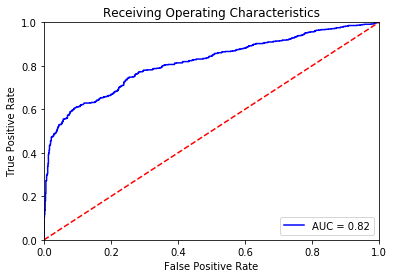

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [49]:
accuracy_matrix.loc[4] = ['SVM', 78, 0.82] 

In [51]:
accuracy_matrix.head()

,Model_Name,accuracy_score,auc
0,Logistic Regression,66.7,0.69
1,Adaptive Boosting Classifier,78.0,0.83
2,Decision Tree,71.7,0.71
3,Random Forest,77.7,0.83
4,SVM,78.0,0.82


# Ques 3: I have extracted two additional features form the dataset:
                1. length of the text 
                2. year of the tournament
From above, it can be observed that Adaptive Boosting and SVM both are giving the best accuracy score of 78%. Hence, I will build my final model using SVM. I will also compare if the above two additional feature increase the accuracy or decrease it by comparing the accuracy score and Area under Curve graph. 

In [28]:
import re
pattern = "^[0-9][0-9][0-9][0-9]"

for index, row in df.iterrows():
    temp = df['tournaments'].values[index]
    year = re.match(pattern, temp)
    df['tournament_year'].values[index] = year.group(0)

In [30]:
for index, row in df.iterrows():
    temp = df['text'].values[index]
    temp = temp.split()
    length = len(temp)
    df['length_text'].values[index] = length

In [51]:
# import re
# var = '2000 ACF Spring'
# pattern = "^[0-9][0-9][0-9][0-9]"
# val = re.match(pattern, var)
# print(val.group(0))

2000


In [57]:
df.head()

,row,body_score,page,answer,text,category,tournaments,answer_type,corr,inlinks,tournament_year,length_text
0,1,127.398036,Comus (John Milton),Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,work,True,62,2000,65
1,2,50.212336,Circe,Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,None,False,5,2000,65
2,3,44.767071,Satyr,Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,None,False,6,2000,65
3,4,44.058274,Philip K. Dick,Wilfred Owen,This author is convinced by another to publish...,Literature,2009 ACF Winter,people,False,22,2009,56
4,5,40.675249,Honore de Balzac,Wilfred Owen,This author is convinced by another to publish...,Literature,2009 ACF Winter,None,False,0,2009,56


In [31]:
X = df.iloc[:, [1,6,7,9,10,11]].values
y = df.iloc[:, 8].values

In [32]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder_tournaments_1 = LabelEncoder()
label_encoder_answer_type = LabelEncoder()
label_encoder_tournament_year = LabelEncoder()

label_encoder_tournaments_1.fit(X[:,1]) #never enter multiple column here, it doesn't work
X[:,1] = label_encoder_tournaments_1.transform(X[:,1])

label_encoder_answer_type.fit(X[:,2]) #never enter multiple column here, it doesn't work
X[:,2] = label_encoder_answer_type.transform(X[:,2])

label_encoder_tournament_year.fit(X[:,4]) #never enter multiple column here, it doesn't work
X[:,4] = label_encoder_tournament_year.transform(X[:,4])

one_hot_encoder = OneHotEncoder(categorical_features=[1,2,4], sparse=False)
one_hot_encoder.fit(X)
X= one_hot_encoder.transform(X)

In [33]:
label_encoder_corr = LabelEncoder()
label_encoder_corr.fit(y) #never enter multiple column here, it doesn't work
y = label_encoder_corr.transform(y)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0 )

In [35]:
svm_class = SVC(kernel='rbf', random_state=0, probability=True)
svm_class.fit(X_train,y_train)
y_pred = svm_class.predict(X_test)

In [36]:
y_pred_prob_final = svm_class.predict_proba(X_test) [:, 1]

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8118811881188119

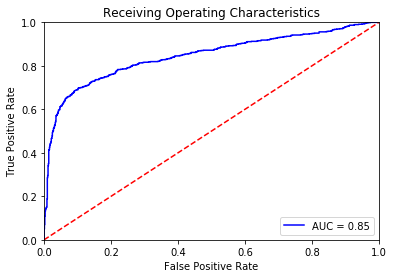

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
plt.title('Receiving Operating Characteristics')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Comparing the ROC curve of SVM model with and without additional features

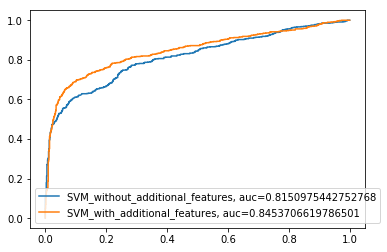

In [45]:
from sklearn import metrics

plt.figure(0).clf()

fig1 = plt.gcf()

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="SVM_without_additional_features, auc="+str(auc))


fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob_final)
auc = metrics.roc_auc_score(y_test, y_pred_prob_final)
plt.plot(fpr,tpr,label="SVM_with_additional_features, auc="+str(auc))

plt.legend(loc=0)

In [47]:
fig1.savefig('plot.pdf', dpi=100)

# Hence, we will build our final classifier using body_score, tournaments, inlinks, answer_type and the two extracted features, length of the text and tournament year